# TABLE OF CONTENTS

* [1. INTRODUCTION](#section-one)
* [2. SETUP](#section-two)
    - [2.1 Draw Packages](#section-two-one)
    - [2.2 Import the Data](#section-two-one)
    - [2.3 Response Variable](#section-two-two)
    - [2.4 Limit the Feature Space](#section-two-three)
        - [2.4.1 Drop features missing more than 30% data](#section-two-four-one)
        - [2.4.2 Only keep loan features known to potential investors](#section-two-four-two)
* [3. EXPLORATORY DATA ANALYSIS](#section-three)
    - [3.1 Pre-processing](#section-three-one)
    - [3.2 Create dummy variables](#section-three-two)
    - [3.3 Train/test split](#section-three-three)
* [4. QUESTIONS](#section-four)
    - [4.1 How do we train and test a model?](#section-four-one)
        - [4.2.1 Logistic regression with SGD training](#section-four-one-one)
        - [4.2.2 Random forest classifier](#section-four-one-two)
        - [4.2.3 k-nearest neighbors](#section-four-one-three)
    - [4.2 Test set evaluation](#section-four-two)
* [5. CONCLUSION](#section-five)
* [6. REFERENCE](#section-six)

<a id="section-one"></a>
# 1. INTRODUCTION

[LendingClub](https://www.lendingclub.com/) is the world's largest peer-to-peer lending platform. How does it work? Here is an explanation by [LendingClub](https://www.lendingclub.com/investing/peer-to-peer):

> Notes are securities that correspond to fractions of loans, sold with 3 or 5 year terms and risk grades A-C. Rather than funding the whole loan, you buy Notes corresponding to multiple loans in increments as low as $25. Borrowers then make monthly payments of both principal and interest. Simply put, your net return ends up being the average interest rate corresponding to your Notes portfolio, less losses and fees.

The focus of this notebook is to deploy machine learning models to predict a P2P loan default. Specifically, if you want to invest in a note on LendingClub, what should you watch out for? We will consider information available on LendingClub loan listing (e.g., loan size, purpose, grade, interest rate, installment) and information about the borrower (e.g., income employment status, length, credit worthiness, debt-to-income ratio.). Furthermore, loans not accepted by LendingClub under its credit underwriting policy are excluded from our sample. 

Furthermore, in the pre-recorded session, we will use only 0.1 million of the 2.5 million observations available to reduce runtime. 

<a id="section-two"></a>
# 2. SETUP

<a id="section-two-one"></a>
# 2.1 Draw Packages

In [1]:
!pip install missingno

import missingno as msno 
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

<a id="section-two-two"></a>
# 2.2 Import the Data

Add data with this URL: https://www.kaggle.com/wordsforthewise/lending-club

In [13]:
loans = pd.read_excel('default of credit card clients.xls', header = 1, index_col = 0)

In [14]:
# Inspect dataset
loans.info()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [16]:
loans.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


The size of the dataset is 2.5 GB with 2.3 million rows and 150 variables.

In [15]:
# To demo with the first 1,000,000 observations
# Please remove this condition if you are serious about investing in P2P note :)
loans = loans.head(1000000)

In [5]:
# Let's take a glimpse into the 5 randomly selected rows. Each row is a single loan.
loans.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
147946,59759264,NaN,16500.0,16500.0,16500.0,60 months,16.99,409.98,D,D3,Customer Success Engineer,2 years,RENT,75000.0,Verified,Sep-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=59759264,NaN,debt_consolidation,Debt consolidation,982xx,WA,25.29,0.0,Jul-2009,665.0,669.0,1.0,NaN,NaN,9.0,0.0,16779.0,82.2,13.0,w,0.00,0.00,17262.390000,17262.39,16500.00,762.39,0.0,0.0,0.0,Jan-2016,16403.50,NaN,May-2018,794.0,790.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,74680.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20400.0,NaN,NaN,NaN,6.0,8298.0,2319.0,82.0,0.0,0.0,31.0,74.0,11.0,5.0,0.0,11.0,NaN,2.0,NaN,0.0,5.0,6.0,5.0,6.0,5.0,6.0,7.0,6.0,9.0,0.0,0.0,0.0,2.0,100.0,60.0,0.0,0.0,86685.0,74680.0,12900.0,66285.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
552060,118552424,NaN,3000.0,3000.0,3000.0,36 months,10.42,97.40,B,B3,Owner,3 years,RENT,25000.0,Source Verified,Sep-2017,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=118552424,NaN,house,Home buying,276xx,NC,18.84,4.0,Apr-1991,690.0,694.0,0.0,12.0,NaN,9.0,0.0,92033.0,22.2,19.0,w,1616.37,1616.37,1741.290000,1741.29,1383.63,357.66,0.0,0.0,0.0,Mar-2019,97.40,Apr-2019,Mar-2019,574.0,570.0,0.0,43.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,93551.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,1.0,0.0,35.0,133100.0,0.0,0.0,0.0,1.0,10395.0,3000.0,0.0,0.0,0.0,NaN,317.0,24.0,24.0,1.0,33.0,12.0,NaN,12.0,1.0,0.0,4.0,3.0,8.0,0.0,8.0,17.0,4.0,9.0,0.0,0.0,0.0,0.0,63.2,0.0,0.0,0.0,134618.0,93551.0,3000.0,0.0

<a id="section-two-three"></a>
# 2.3 Response Variable

`loan_status` is the response variable we want to predict. What is the distribution of the type of loan status?

In [6]:
# Show the distribution of loan status, excluding missing values
loans['loan_status'].value_counts(dropna=True)

Fully Paid            450285
Current               411982
Charged Off           121189
Late (31-120 days)     10475
In Grace Period         3997
Late (16-30 days)       2040
Default                   20
Name: loan_status, dtype: int64

We are interested at the outcome of whether a loan is "fully paid" or not (by note maturity). So we only keep the loans with status "Fully Paid", "Charged Off", "Default", or "Late (31-120 days)."  Excluded from our sample are:   
1. Current loans, of which repayment outcome is uncertain.   
2. Loans that do not meet the credit policy

We're going to try to learn differences in the features between completed loans that have been fully paid or charged off. We won't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. 

In [7]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default', 'Late (31-120 days)'])]

How many loans remain in the dataset?

In [8]:
loans.shape

(581969, 151)

There are 581,969 loans left.

In [9]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid            450285
Charged Off           121189
Late (31-120 days)     10475
Default                   20
Name: loan_status, dtype: int64

Status counts as percentages:

In [10]:
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid            0.773727
Charged Off           0.208240
Late (31-120 days)    0.017999
Default               0.000034
Name: loan_status, dtype: float64

77% of the loans have been fully repaid. Unbalanced classification problem is a potential issue. More details [HERE](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/). 

In [11]:
# Change the response variable `loan_status` to a 0/1 variable, where 0 indicates fully paid and 1 indicates charge-off:

loans['non_repayment'] = (loans['loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)'])).apply(np.uint8)

<a id="section-two-four"></a>
# 2.4 Limit the Feature Space

Each loan has 150 features. Feature selection follows a two-step approach:

1. Drop features with more than 30% of their data missing.
2. Choose features available to an investor before investing in a note.

<a id="section-two-four-one"></a>
## 2.4.1 Drop features missing more than 30% data

In [12]:
# Calculate the percentage of missing data for each feature:
# Sort dataset from observations with the most to the least missing data
    
missing_fractions = loans.isnull().mean().sort_values(ascending=False)

In [13]:
# Inspect top 20 features with the most data:

missing_fractions.head(20)

member_id                                     1.000000
desc                                          0.999918
orig_projected_additional_accrued_interest    0.995118
hardship_loan_status                          0.993259
hardship_reason                               0.993259
hardship_status                               0.993259
deferral_term                                 0.993259
hardship_amount                               0.993259
hardship_start_date                           0.993259
hardship_end_date                             0.993259
hardship_length                               0.993259
hardship_dpd                                  0.993259
payment_plan_start_date                       0.993259
hardship_payoff_balance_amount                0.993259
hardship_last_payment_amount                  0.993259
hardship_type                                 0.993259
sec_app_mths_since_last_major_derog           0.992501
next_pymnt_d                                  0.981966
sec_app_re

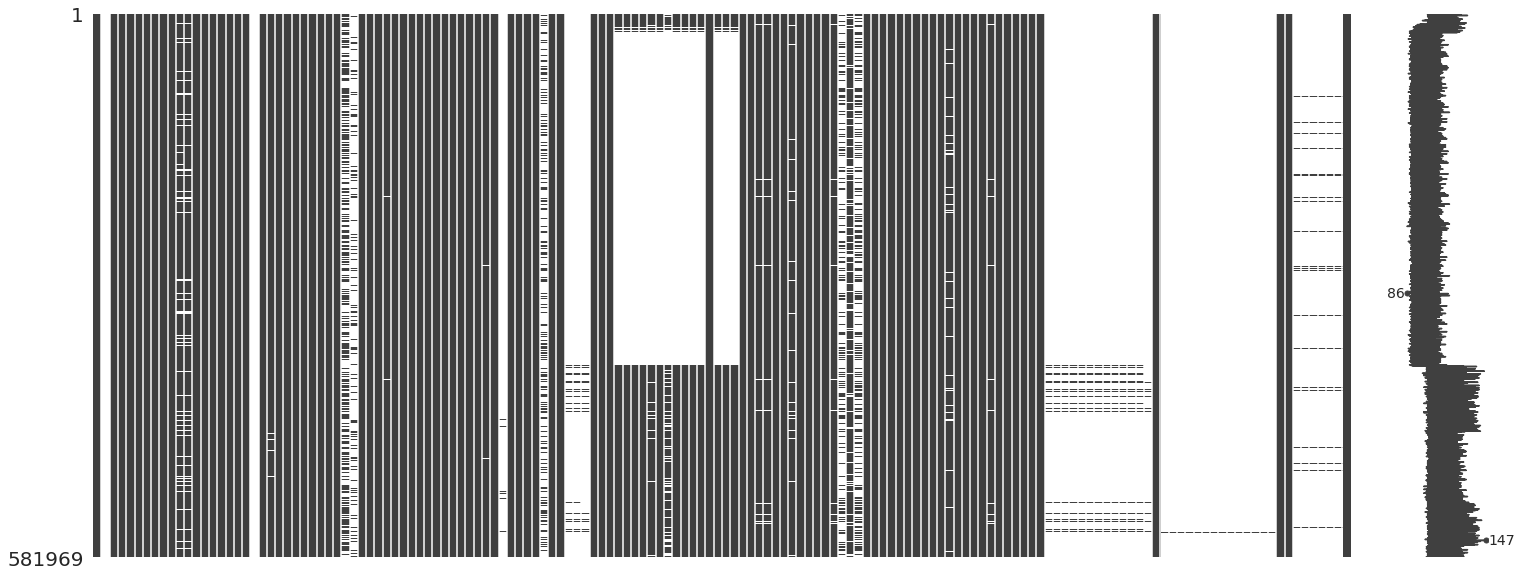

In [14]:
# Visualizing missingness of the dataset

msno.matrix(loans)

Let's visualize the distribution of missing data percentages:

Text(0, 0.5, 'Feature count')

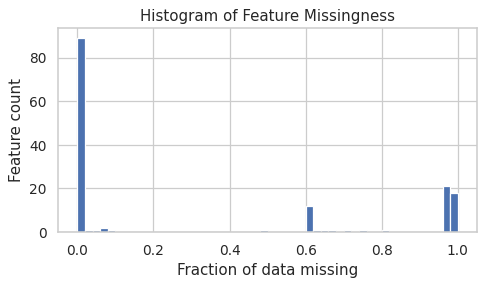

In [15]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=50)
plt.title('Histogram of Feature Missingness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

We see there's a large wedge between features missing "some" data (&lt;20%) and those missing "lots" of data (&gt;40%). Imputing data accurately 30% missing values can be a challenge, so we drop such columns. Let's store all variables missing more than 30% data in an alphabetical list:

In [16]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

How many features will be dropped?

In [17]:
len(drop_list)

58

Drop these features:

In [18]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [19]:
loans.shape

(581969, 94)

<a id="section-two-four-two"></a>
## 2.4.2 Only keep loan features known to potential investors

We examine the LendingClub website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features we currently have, in alphabetical order:

In [20]:
print(sorted(loans.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'non_repayment', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_b

For each of these features, we check the description in the Data Dictionary and only keep the features that would have been available to investors considering an investment in the loan. These include features in the loan application, and any features added by LendingClub when the loan listing was accepted, such as the loan grade and interest rate.

In [21]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code','non_repayment','non_repayment_category']

In [22]:
len(keep_list)

33

The list of features to drop is any feature not in `keep_list`:

In [23]:
drop_list = [col for col in loans.columns if col not in keep_list]
print(drop_list)

['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'url', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc

In [24]:
len(drop_list)

62

Drop these features:

In [25]:
loans.drop(labels=drop_list, axis=1, inplace=True)

<a id="section-three"></a>
# 3. EXPLORATORY DATA ANALYSIS

<a id="section-three-one"></a>
## 3.1 Pre-processing

What do you have in the feature space (the list of potential determinants of loan non-repayment)?

As an illustration, I will only inspect 8 features (4 numerical and 4 categorical features). The selection is based on my priors as whether they can predict non-repayment. The features are:

**Numerical variables:** int_rate, term, fico_score, loan_amnt   
**Categorical variables:** sub_grade, home_ownership, verification, purpose


1. Review the summary statistics, visualize the data, and plotting the data against the loan status with a function.
1. Drop features that do not discriminate well fully repaid vs non-repayment.
1. Change a feature so to increase its predictive value, if necessary.

### Numerical Variables
1. id: A unique [LendingClub] assigned ID for the loan listing.
1. loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
1. term: The number of payments on the loan. Values are in months and can be either 36 or 60
1. int_rate: Interest Rate on the loan
1. installment: The monthly payment owed by the borrower if the loan originates.
1. emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
1. annual_inc: The self-reported annual income provided by the borrower during registration.
1. zip_code: The first 3 numbers of the zip code provided by the borrower in the loan application.
1. dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
1. earliest_cr_line: The month the borrower's earliest reported credit line was opened.
1. fico_range_low: The lower boundary range the borrower’s FICO at loan origination belongs to.
1. fico_range_high: The upper boundary range the borrower’s FICO at loan origination belongs to.
1. open_acc: The number of open credit lines in the borrower's credit file.
1. pub_rec: Number of derogatory public records.
1. revol_bal: Total credit revolving balance.
1. revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
1. total_acc: The total number of credit lines currently in the borrower's credit file.
1. mort_acc: Number of mortgage accounts.
1. pub_rec_bankruptcies: Number of public record bankruptcies.

### Categorical Variables
1. sub_grade: LendingClub assigned loan subgrade
1. grade: LendingClub assigned loan grade
1. home_ownership: The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER.
1. verification_status: Indicates if income was verified by [Lending Club], not verified, or if the income source was verified.
1. purpose: A category provided by the borrower for the loan request.
1. addr_state: The state provided by the borrower in the loan application.
1. initial_list_status: The initial listing status of the loan. Possible values are – W (whole loan), F (fractional loan).
1. application_type: Indicates whether the loan is an individual application or a joint application with two co-borrowers.
1. emp_title: The job title supplied by the Borrower when applying for the loan.
1. issue_d: The month which the loan was funded.
1. title: The loan title provided by the borrower.



In [26]:
def plot_var(feature, feature_name, continuous):
    
    # Visualize a variable with and without the loan status.
    # 1. feature is the variable name in the dataframe
    # 2. feature_name is the full variable name
    # 3. continuous is True if the variable is continuous, False otherwise
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24,8))
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[feature].notnull(), feature], kde=False, ax=ax1)
    else:
        sns.countplot(loans[feature], order=sorted(loans[feature].unique()), saturation=1, ax=ax1)
        
    ax1.set_xlabel(feature_name)
    ax1.set_ylabel('Count')
    ax1.set_title(feature_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=feature, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(feature_name + ' by Repayment Status')
    else:
        charge_off_rates = loans.groupby(feature)['loan_status'].value_counts(normalize=True).loc[:,["Charged Off", "Default", "Fully Paid", "Late (31-120 days)"]]
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Not Repaid')
        ax2.set_title('Non-Repayment Rate by ' + feature_name)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, horizontalalignment='right')
        ax2.set_xlabel(feature_name)
    
    plt.tight_layout()

<a id="section-three-one-one"></a>
### 3.1.1 Interest Rate

int_rate: Interest Rate on the loan

In [27]:
loans['int_rate'].describe()

count    581969.000000
mean         12.809860
std           4.806562
min           5.310000
25%           9.170000
50%          12.290000
75%          15.610000
max          30.990000
Name: int_rate, dtype: float64

Interest rates range from 5.31% to 30.99% (!) with a median of 12.29%.

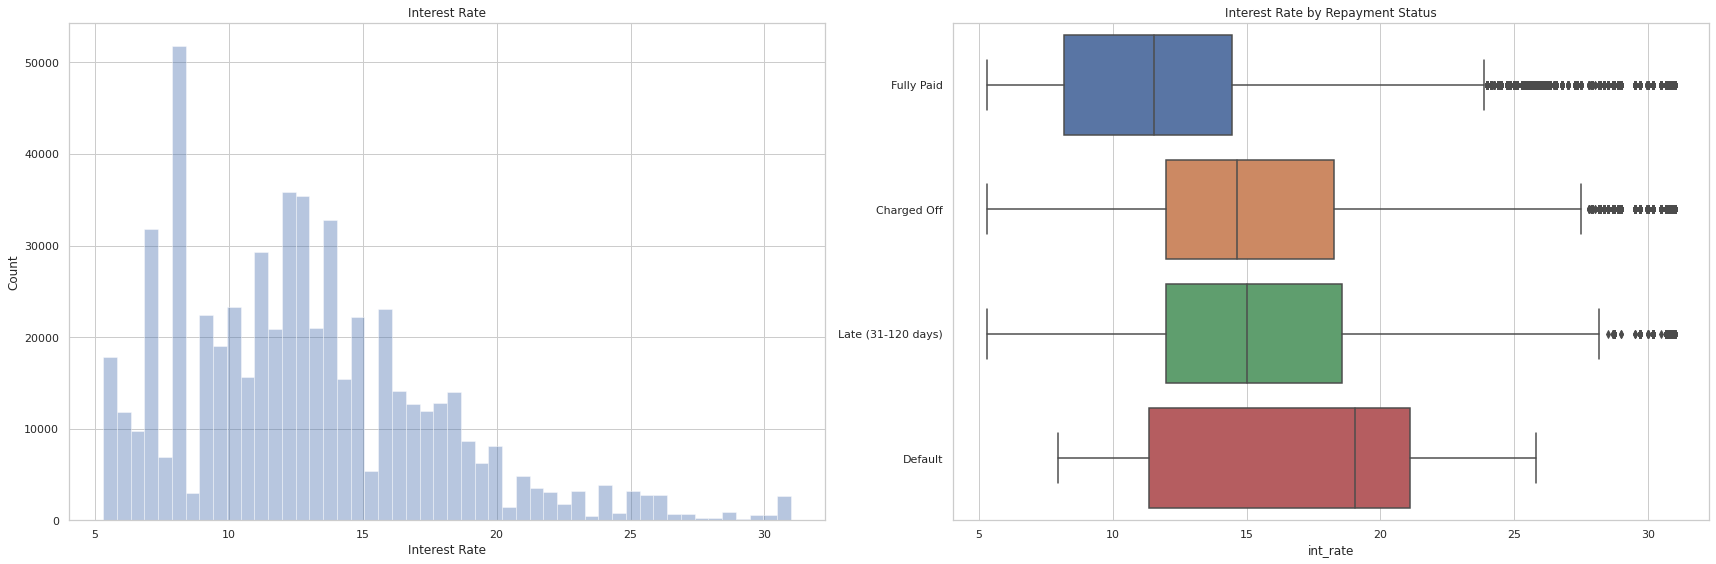

In [28]:
plot_var('int_rate', 'Interest Rate', continuous=True)

Fully repaid loans tend to have much lower interest rates. Let's compare the summary statistics by loan status:

In [29]:
loans.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,121189.0,15.375897,4.958496,5.31,11.9900,14.65,18.250,30.99
Default,20.0,17.270500,5.830956,7.97,11.3675,19.03,21.105,25.82
Fully Paid,450285.0,12.052806,4.476698,5.31,8.1800,11.53,14.460,30.99
Late (31-120 days),10475.0,15.657193,5.347756,5.31,11.9900,15.02,18.550,30.99


<a id="section-three-one-two"></a>
### 3.1.2 Loan Term

term: The number of payments on the loan. Values are in months and can be either 36 or 60

In [30]:
loans['term'].value_counts(dropna=False)

 36 months    439529
 60 months    142440
Name: term, dtype: int64

In [31]:
#Convert term to integers
loans['term'] = loans['term'].apply(lambda s: np.int8(s.split()[0]))

In [32]:
loans['term'].value_counts(normalize=True)

36    0.755245
60    0.244755
Name: term, dtype: float64

Compare the charge-off rate by loan period:

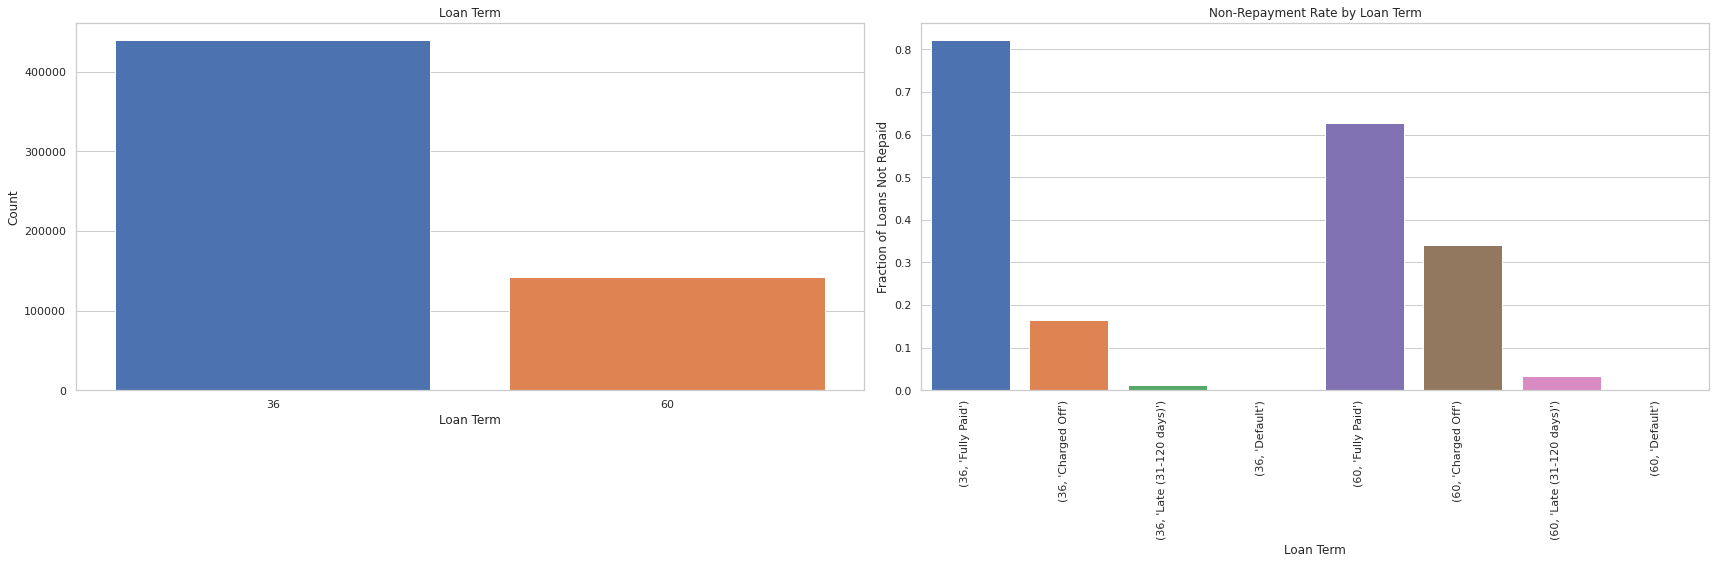

In [33]:
plot_var('term', 'Loan Term', continuous=False)

<a id="section-three-one-three"></a>
### 3.1.3 FICO

fico_range_low: The lower boundary range the borrower’s FICO at loan origination belongs to.  
fico_range_high: The upper boundary range the borrower’s FICO at loan origination belongs to.

In [34]:
loans[['fico_range_low', 'fico_range_high']].describe()

,fico_range_low,fico_range_high
count,581969.000000,581969.000000
mean,695.378732,699.378884
std,31.816385,31.817106
min,660.000000,664.000000
25%,670.000000,674.000000
50%,690.000000,694.000000
75%,710.000000,714.000000
max,845.000000,850.000000


In [35]:
loans[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


Let's take the average of the two and remove the two original variables.

In [36]:
loans['fico_score'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']

In [37]:
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

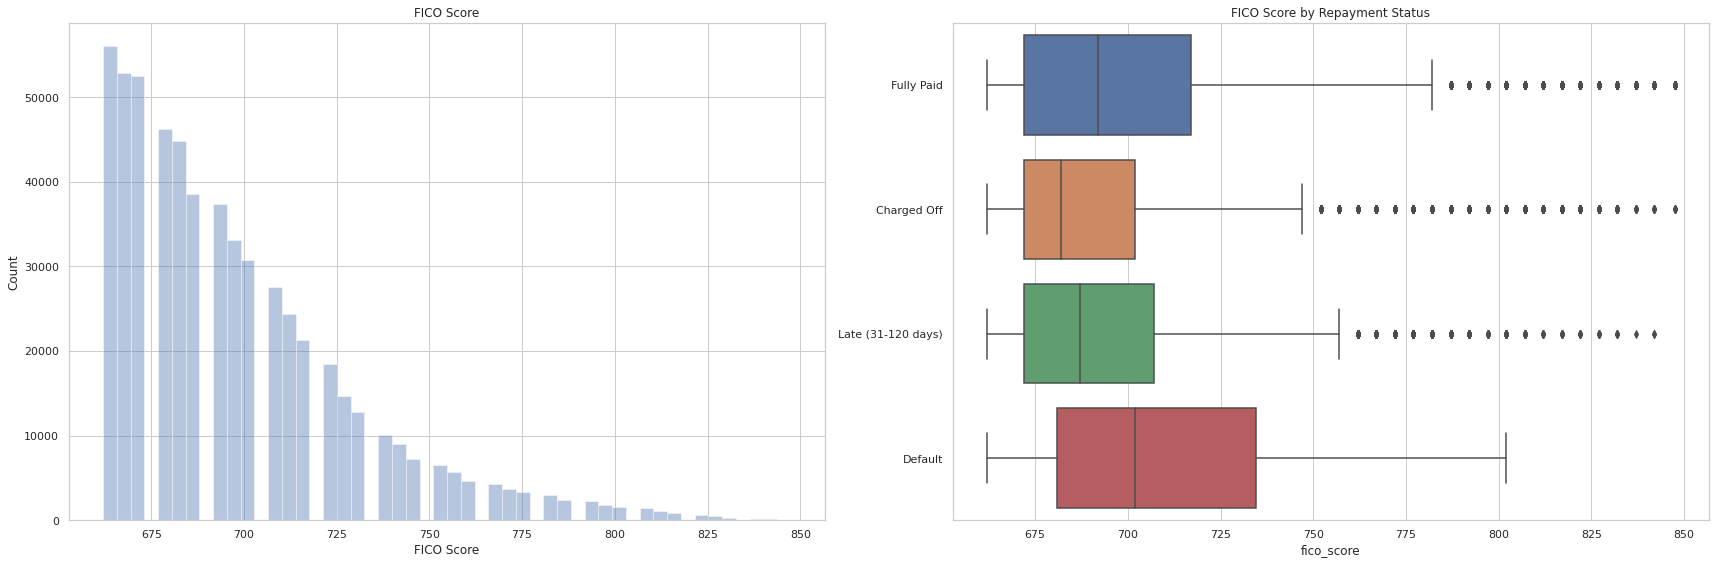

In [38]:
plot_var('fico_score', 'FICO Score', continuous=True)

In [39]:
loans.groupby('loan_status')['fico_score'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,121189.0,689.134954,25.705709,662.0,672.00,682.0,702.0,847.5
Default,20.0,709.500000,39.917678,662.0,680.75,702.0,734.5,802.0
Fully Paid,450285.0,699.670479,32.972391,662.0,672.00,692.0,717.0,847.5
Late (31-120 days),10475.0,694.220525,28.940459,662.0,672.00,687.0,707.0,842.0


<a id="section-three-one-four"></a>
### 3.1.4 Loan Amount

loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

In [40]:
loans['loan_amnt'].describe()

count    581969.000000
mean      14606.557909
std        8837.389618
min        1000.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

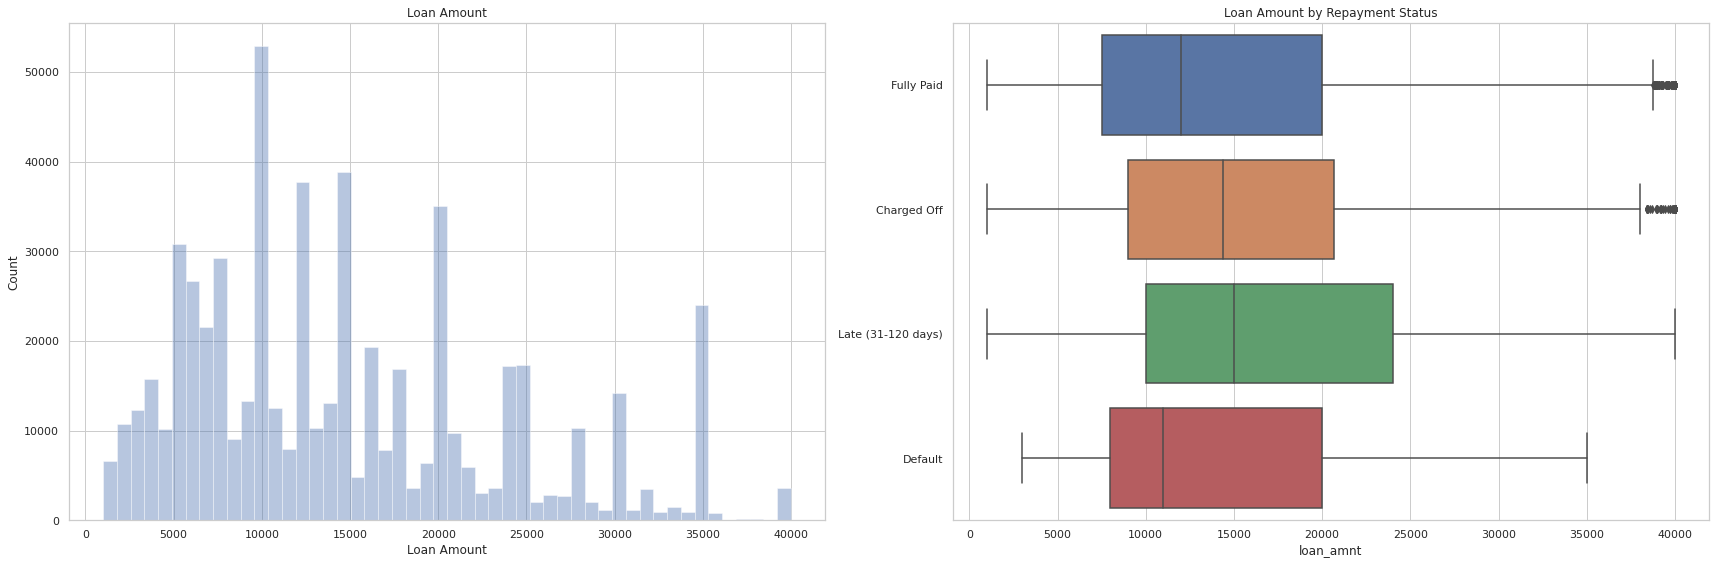

In [41]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

Charged-off loans tend to have higher loan amounts.

In [42]:
loans.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,121189.0,15654.472766,8811.053292,1000.0,9000.0,14400.0,20700.0,40000.0
Default,20.0,14566.250000,9513.004517,3000.0,8000.0,11000.0,20000.0,35000.0
Fully Paid,450285.0,14264.980901,8791.914710,1000.0,7500.0,12000.0,20000.0,40000.0
Late (31-120 days),10475.0,17166.181384,9678.240476,1000.0,10000.0,15000.0,24000.0,40000.0


<a id="section-three-one-five"></a>
### 3.1.5 Grade and subgrade

sub_grade: LendingClub assigned loan subgrade   
grade: LendingClub assigned loan grade

In [43]:
print(sorted(loans['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [44]:
print(sorted(loans['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The grade is implied by the subgrade, so let's drop the grade column.

In [45]:
loans.drop('grade', axis=1, inplace=True)

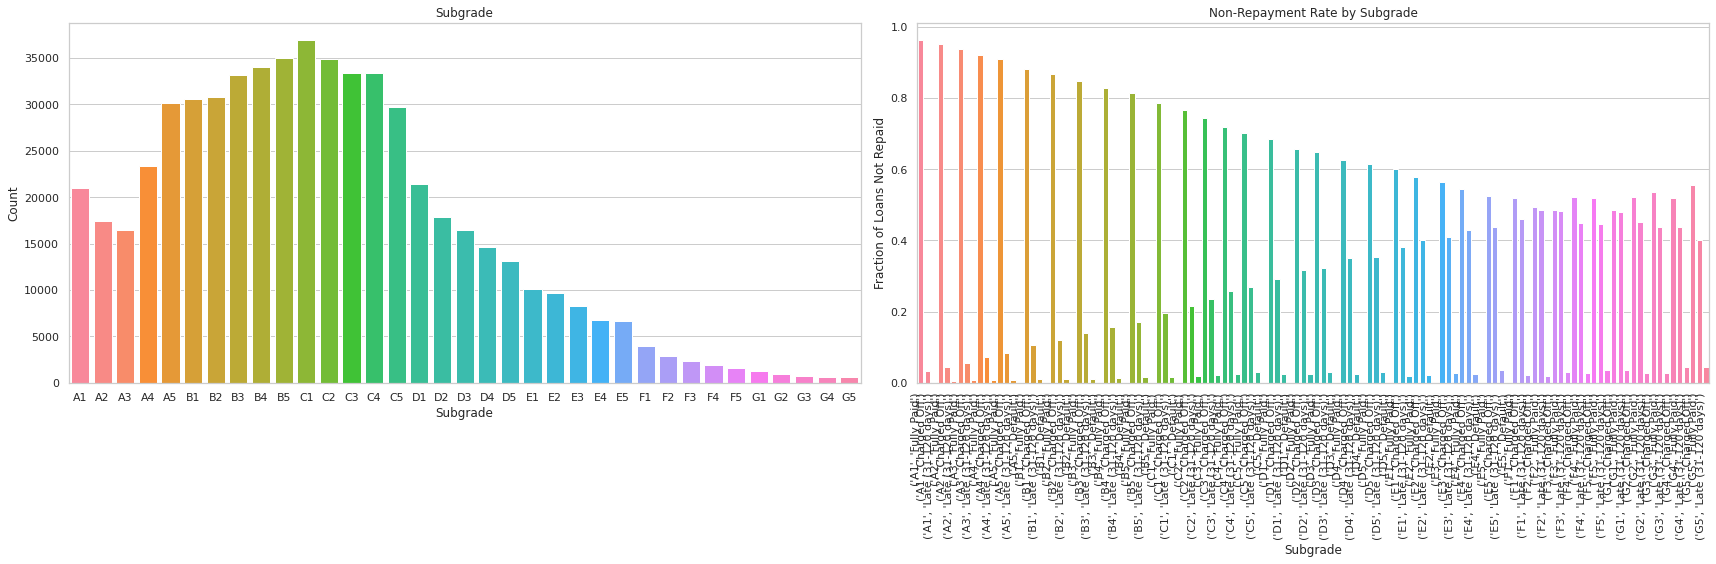

In [46]:
plot_var('sub_grade', 'Subgrade', continuous=False)

There's a clear trend of higher probability of non-repayment as the subgrade worsens.

<a id="section-three-one-six"></a>
### 3.1.6 Homeownership

Home ownership: The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER.

In [47]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    283545
RENT        232089
OWN          66312
ANY             21
NONE             2
Name: home_ownership, dtype: int64

Replace the values `ANY` and `NONE` with `OTHER`:

In [48]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [49]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    283545
RENT        232089
OWN          66312
OTHER           23
Name: home_ownership, dtype: int64

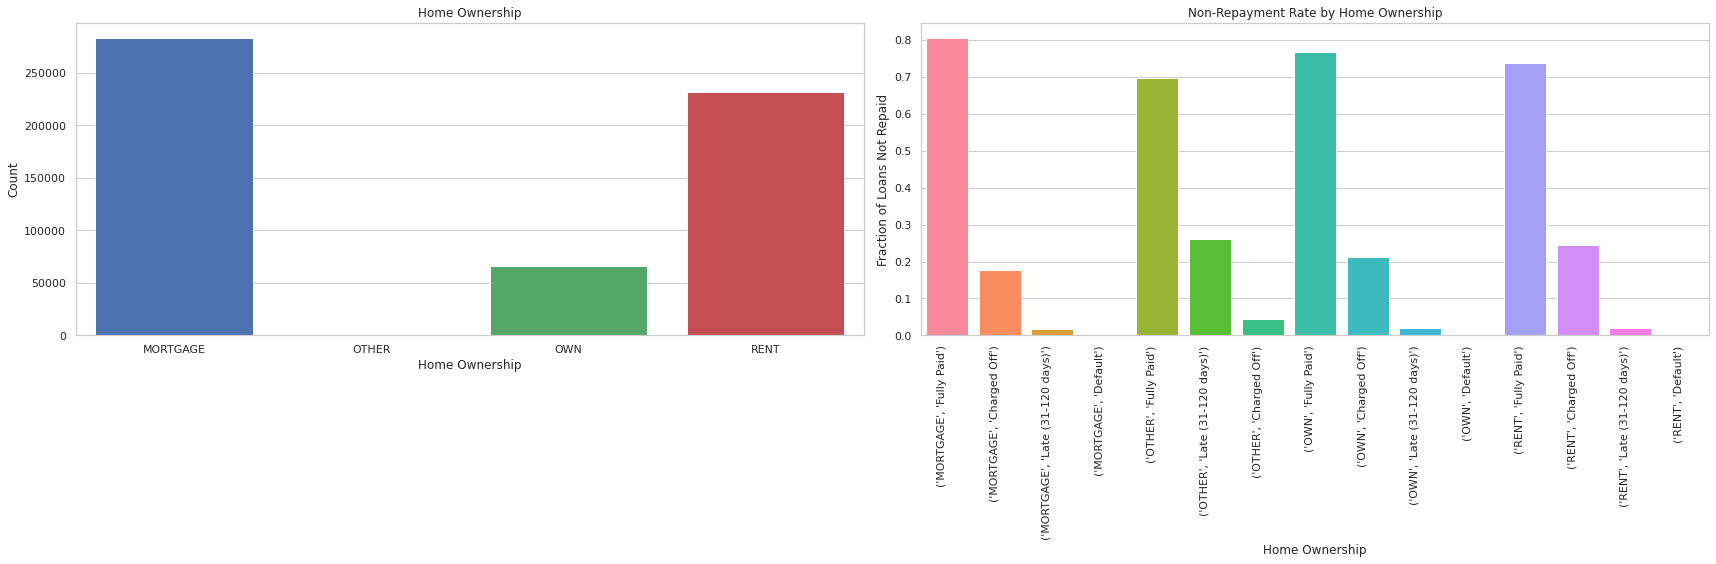

In [50]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

There appear to be large differences in non-repayment rates by home ownership status. Renters and homeowners have a higher probability of non-repayment. Let's compare the non-repayment rates:

In [51]:
loans.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,["Charged Off", "Default", "Fully Paid", "Late (31-120 days)"]]

home_ownership  loan_status       
MORTGAGE        Fully Paid            0.805929
                Charged Off           0.177834
                Late (31-120 days)    0.016206
                Default               0.000032
OTHER           Fully Paid            0.695652
                Late (31-120 days)    0.260870
                Charged Off           0.043478
OWN             Fully Paid            0.768021
                Charged Off           0.212284
                Late (31-120 days)    0.019619
                Default               0.000075
RENT            Fully Paid            0.736024
                Charged Off           0.244247
                Late (31-120 days)    0.019704
                Default               0.000026
Name: loan_status, dtype: float64

<a id="section-three-one-seven"></a>
### 3.1.7 Verification Status

verification_status: Indicates if income was verified by [Lending Club], not verified, or if the income source was verified.

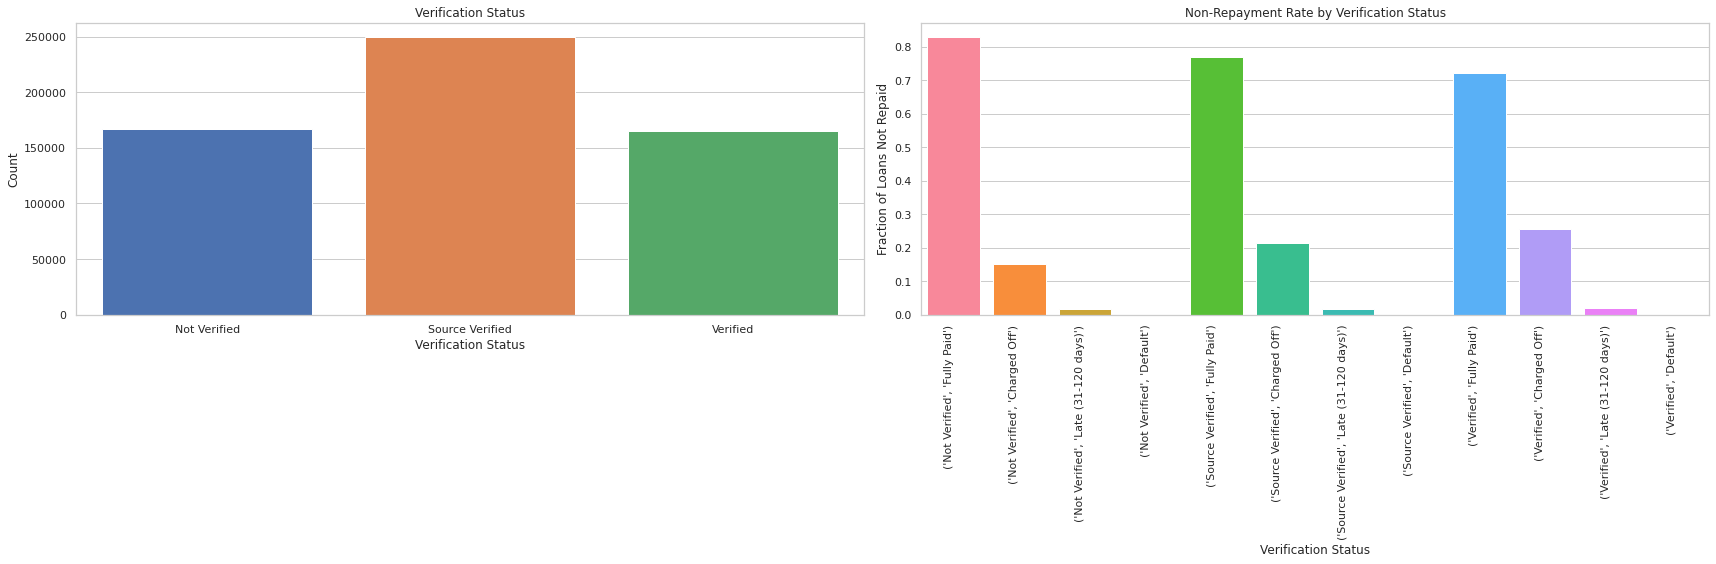

In [52]:
plot_var('verification_status', 'Verification Status', continuous=False)

<a id="section-three-one-eight"></a>
### 3.1.8 Loan Purpose

Loan purpose: A category provided by the borrower for the loan request.

In [53]:
loans['purpose'].value_counts()

debt_consolidation    337874
credit_card           129632
home_improvement       39571
other                  33281
major_purchase         12260
medical                 6752
car                     5694
small_business          5345
moving                  4184
vacation                4166
house                   2845
renewable_energy         358
wedding                    6
educational                1
Name: purpose, dtype: int64

Calculate the charge-off rates by purpose:

In [54]:
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,["Charged Off", "Default", "Fully Paid", "Late (31-120 days)"]].sort_values()

purpose             loan_status       
credit_card         Default               0.000015
other               Default               0.000030
debt_consolidation  Default               0.000038
home_improvement    Default               0.000051
major_purchase      Default               0.000082
medical             Default               0.000148
credit_card         Late (31-120 days)    0.015081
car                 Late (31-120 days)    0.016333
vacation            Late (31-120 days)    0.016803
home_improvement    Late (31-120 days)    0.017917
debt_consolidation  Late (31-120 days)    0.018243
moving              Late (31-120 days)    0.020076
medical             Late (31-120 days)    0.021327
other               Late (31-120 days)    0.021724
renewable_energy    Late (31-120 days)    0.022346
major_purchase      Late (31-120 days)    0.022757
house               Late (31-120 days)    0.029174
small_business      Late (31-120 days)    0.030496
car                 Charged Off           0

Notice that only 16.7% of completed loans for weddings have not repaid, but 31% of completed small business loans have not repaid.

In [55]:
# Subset data to the 8 features and the target
# Modify your set of features here
loans = loans[["issue_d","non_repayment","int_rate", "term", "fico_score", "loan_amnt", "sub_grade", "home_ownership", "verification_status", "purpose"]]

<a id="section-three-two"></a>
### 3.2 Create dummy variables

In [56]:
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose'], drop_first=True)

In [57]:
loans.shape

(581969, 58)

Check our data with the new dummy variables:

In [58]:
loans.sample(5)

,issue_d,non_repayment,int_rate,term,fico_score,loan_amnt,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
127335,Oct-2015,0,16.99,36,662.0,4350.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
25438,Dec-2015,0,11.22,36,687.0,10000.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
56549,Nov-2015,0,9.99,36,712.0,5400.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
714630,Apr-2016,0,11.47,36,697.0,30000.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
177525,Aug-2015,1,13.99,36,677.0,20000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0


<a id="section-three-three"></a>
### 3.3 Train/Test Split

We'll make our modeling problem more realistic by performing the train/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict whether future loans will charge-off. The variable `issue_d` includes the month and year that the loan was funded.

In [59]:
loans['issue_d'].sample(5)

657573    Jun-2016
8819      Dec-2015
238901    Jul-2015
174665    Aug-2015
213916    Jul-2015
Name: issue_d, dtype: object

Are there any missing values?

In [60]:
loans['issue_d'].isnull().any()

False

No. Let's convert the issue dates to datetime objects:

In [61]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'])

In [62]:
loans['issue_d'].sample(5)

119704   2015-10-01
203069   2015-07-01
509247   2018-01-01
714098   2016-04-01
951145   2017-05-01
Name: issue_d, dtype: datetime64[ns]

The new datetime values are all on the first day of the month. Check the summary statistics of the issue dates:

In [63]:
loans['issue_d'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  581969
unique                     28
top       2015-10-01 00:00:00
freq                    43158
first     2015-01-01 00:00:00
last      2018-09-01 00:00:00
Name: issue_d, dtype: object

There are only 28 unique issue dates for the first 1 million loans. Note that we only have month/year information. In this subset, the first loans were issued in January 2015, and the most recent loans were issued in September 2018. The busiest month was October 2015. What is the distribution of loans funded in each year?

Text(0.5, 1.0, 'Loans Funded per Year')

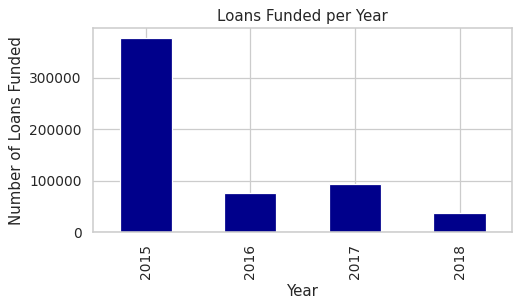

In [64]:
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

We'll form the test set from the most recent 10% of the loans.

In [65]:
loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.9)]
loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)]

Check that we properly partitioned the loans:

In [66]:
print('Number of loans in the partition:   ', loans_train.shape[0] + loans_test.shape[0])
print('Number of loans in the full dataset:', loans.shape[0])

Number of loans in the partition:    581969
Number of loans in the full dataset: 581969


What is the test size?

In [67]:
loans_test.shape[0] / loans.shape[0]

0.11561784218747047

About 11.6%. The partition looks good, so we can delete the original `loans` dataframe:

Let's look at the summary statistics of the issue dates in the train and test sets:

In [68]:
loans_train['issue_d'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  514683
unique                     20
top       2015-10-01 00:00:00
freq                    43158
first     2015-01-01 00:00:00
last      2017-07-01 00:00:00
Name: issue_d, dtype: object

In [69]:
loans_test['issue_d'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   67286
unique                      8
top       2017-08-01 00:00:00
freq                    16307
first     2017-08-01 00:00:00
last      2018-09-01 00:00:00
Name: issue_d, dtype: object

The training set includes loans from January 2015 to July 2017. The test set includes loans from August 2017 to September 2018.

Now we need to delete the `issue_d` variable, because it was not available before the loan was funded.

In [70]:
loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<a id="section-four"></a>
# 4. QUESTIONS

Separate training and testing dataset

In [71]:
y_train = loans_train['non_repayment']
y_test = loans_test['non_repayment']

In [72]:
X_train = loans_train.drop('non_repayment', axis=1)
X_test = loans_test.drop('non_repayment', axis=1)

In [73]:
del loans_train, loans_test

### Model Training and Testing

We implement machine learning pipelines consisting of one or more of the following steps, depending on the particular model:
1. Mean imputation of missing values
2. Dimension reduction using linear discriminant analysis (LDA)
3. Data standardization: rescaling to zero mean and unit variance
4. The chosen model

We will evaluate and compare the following models using a cross-validated AUROC score on the training set:
1. Logistic regression with SGD training
2. Random forest
3. k-nearest neighbors

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

<a id="section-three"></a>
## 4.1 Logistic regression with SGD training

The `SGDClassifier` estimator in scikit-learn implements linear classifiers (SVM, logistic regression, and others) with stochastic gradient descent (SGD) training. A particular linear classifier is chosen through the `loss` hyperparameter. Because we want to predict the probability of charge-off, we choose logistic regression (a probabilistic classifier) by setting `loss = 'log'`.

In [75]:
from sklearn.linear_model import SGDClassifier

More on Stochastic Gradient Descent (SGD) [HERE](https://campus.datacamp.com/courses/linear-classifiers-in-python/support-vector-machines?ex=10).

The machine learning pipeline [More HERE](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf):

In [76]:
pipeline_sgdlogreg = Pipeline([
    
    # Imputation in-place
    # Mean imputation by default
    ('imputer', SimpleImputer(copy=False)), 
    
    # Standardize features by removing the mean and scaling to unit variance
    # The standard score of a sample x is calculated as:
    # z = (x - u) / s
    ('scaler', StandardScaler(copy=False)),  
    
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

"Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance). For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected." [Scikit Learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 

“Regularization is any modification we make to a learning algorithm that is intended to reduce its generalization error but not its training error.” ~ Ian Goodfellow

A small grid of hyperparameters to search over:

In [77]:
param_grid_sgdlogreg = {
    # Regularization parameter: Higher regularization value -> smoother classifier -> less risk of overfitting but lower accuracy on training data
    'model__alpha': [10**-5, 10**-2, 10**1],
    # Regularization method
    'model__penalty': ['l1', 'l2']
}

Create the search grid object:

In [78]:

grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

Conduct the grid search and train the final model on the whole dataset:

In [79]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('scaler', StandardScaler(copy=False)),
                                       ('model',
                                        SGDClassifier(loss='log',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=1,
             param_grid={'model__alpha': [1e-05, 0.01, 10],
                         'model__penalty': ['l1', 'l2']},
             pre_dispatch=1, scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [80]:
grid_sgdlogreg.best_score_

0.7165869749481637

Best hyperparameters:

In [81]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

[[391808   9045]
 [102656  11174]]


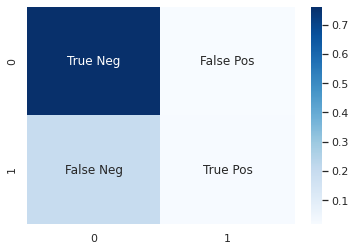

In [82]:
# Generate predictions with the model using our X values
y_pred = grid_sgdlogreg.predict(X_train)

# Get the confusion matrix
cf_matrix = confusion_matrix(y_train, y_pred)
print(cf_matrix)

labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, fmt="", cmap="Blues")

<a id="section-four-two"></a>
## 4.2 Random forest classifier

Next we train a random forest model. Note that data standardization is not necessary for a random forest.

In [83]:
from sklearn.ensemble import RandomForestClassifier

More on Random Forest [HERE](https://www.datacamp.com/community/tutorials/random-forests-classifier-python).

In [84]:
pipeline_rfc = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

The random forest takes very long to train, so we don't test different hyperparameter choices. We'll still use `GridSearchCV` for the sake of consistency.

In [85]:
param_grid_rfc = {
    'model__n_estimators': [50] # The number of randomized trees to build
}

The AUROC improves as the number of estimators increases but with decreasing gain. The cost is the extra training time and model complexity.

In [86]:
grid_rfc = GridSearchCV(estimator=pipeline_rfc, param_grid=param_grid_rfc, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

More on GridSearchCV [HERE](https://towardsdatascience.com/grid-search-for-hyperparameter-tuning-9f63945e8fec).

In [87]:
grid_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             n_jobs=1, param_grid={'model__n_estimators': [50]}, pre_dispatch=1,
             scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the random forest:

In [88]:
grid_rfc.best_score_

0.6266395776864393

Not quite as good as logistic regression, at least according to this metric.

[[395226   5627]
 [ 20236  93594]]


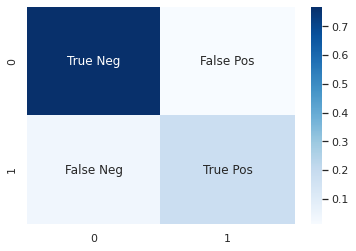

In [89]:
# Generate predictions with the model using our X values
y_pred = grid_rfc.predict(X_train)

# Get the confusion matrix
cf_matrix = confusion_matrix(y_train, y_pred)
print(cf_matrix)

labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, fmt="", cmap="Blues")

<a id="section-four-three"></a>
## 4.3 k-nearest neighbors

Next we try k-nearest neighbors. We need to reduce the number of variables to 10 or fewer ([reference](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Dimension_reduction)) for kNN to perform well. We'll use LDA for dimension reduction. The number of component variables to keep is a hyperparameter.

In [90]:
from sklearn.neighbors import KNeighborsClassifier

In [91]:
pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('scaler', StandardScaler(copy=False)),
    ('lda', LinearDiscriminantAnalysis()),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

More on KNN [HERE](https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn).

In [92]:
param_grid_knn = {
    'lda__n_components': [1], # Number of LDA components to keep
    'model__n_neighbors': [5, 25, 125] # The 'k' in k-nearest neighbors
}

In [93]:
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

More on GridSearchCV [HERE](https://towardsdatascience.com/grid-search-for-hyperparameter-tuning-9f63945e8fec).

In [94]:
grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('scaler', StandardScaler(copy=False)),
                                       ('lda', LinearDiscriminantAnalysis()),
                                       ('model',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=1,
             param_grid={'lda__n_components': [1],
                         'model__n_neighbors': [5, 25, 125]},
             pre_dispatch=1, scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [95]:
grid_knn.best_score_

0.7078990471876713

Best hyperparameters:

In [96]:
grid_knn.best_params_

{'lda__n_components': 1, 'model__n_neighbors': 125}

Only 1 LDA components is necessary for kNN to perform almost as well as logistic regression!

[[389776  11077]
 [100030  13800]]


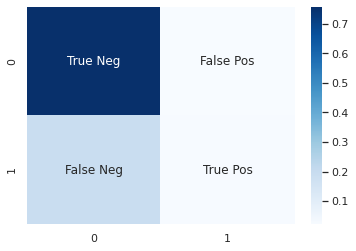

In [97]:
# Generate predictions with the model using our X values
y_pred = grid_knn.predict(X_train)

# Get the confusion matrix
cf_matrix = confusion_matrix(y_train, y_pred)
print(cf_matrix)

labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, fmt="", cmap="Blues")

<a id="section-four-two"></a>
## 4.2 Test set evaluation

Now we can finally see how our chosen model performs on the test data (the most recent 10% of the chosen subset of loans on LendingClub).

In [98]:
from sklearn.metrics import roc_auc_score

In [99]:
y_score = grid_sgdlogreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_score)

0.6870608582184101

The test set AUROC score is somewhat lower than the cross-validated score (0.687).

[[47043  2389]
 [15404  2450]]


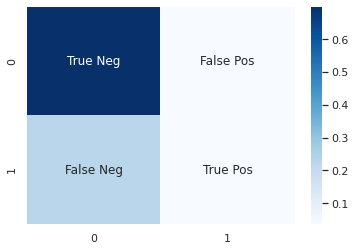

In [100]:
# Generate predictions with the model using our X values
y_pred = grid_sgdlogreg.predict(X_test)

# Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, fmt="", cmap="Blues")

<a id="section-five"></a>
# 5. CONCLUSION

We explore three machine learning methods to estimate the probability of non-payment of a requested loan on LendingClub: logistic regression, random forest, and k-nearest neighbors. We train, evaluate, and find that the performance for all the models - they are somewhat similar using a cross-validated AUROC score on the training data. Eventually, we choose logistic regression (with ridge penalty) because of its execution speed is the fastest and its AUROC score the highest. This model has an AUROC score of 0.687 on a test dataset with the most recent 10% loans/notes.

This model offers insight into how likely a loan will not be repaid. The model builds upon features assessible by prospective investors (before the loan is fully funded).

<a id="section-six"></a>
# 6. REFERENCE

This notebook is adapted from a version coded by [Joe Corliss](https://www.kaggle.com/pileatedperch). The original dataset, which is aggregated on Kaggle, is available [HERE](https://www.lendingclub.com/info/download-data.action). The dataset, which is hosted on Kaggle, for this notebook is available [HERE](https://www.kaggle.com/wordsforthewise/lending-club).